# Pytorch Implementation of Legendre Memory Units, psMNIST Example

In [1]:
from functools import partial
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchlmu import LMU, LMUCell, lecun_uniform_

In [2]:
def setSeed(seed):
    """ Set all seeds to ensure reproducibility """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def stateSpaceMatrices(memory_size, theta):
    """ Returns the discretized state space matrices A and B """

    Q = np.arange(memory_size, dtype = np.float64).reshape(-1, 1)
    R = (2*Q + 1) / theta
    i, j = np.meshgrid(Q, Q, indexing = "ij")

    # Continuous
    A = R * np.where(i < j, -1, (-1.0)**(i - j + 1))
    B = R * ((-1.0)**Q)
    C = np.ones((1, memory_size))
    D = np.zeros((1,))

    # Convert to discrete
    from scipy.signal import cont2discrete
    A, B, C, D, _ = cont2discrete(
        system = (A, B, C, D), 
        dt = 1.0, 
        method = "zoh"
    )
    
    return A, B


In [3]:
class LMUCellOld(nn.Module):
    def __init__(self, input_size, hidden_size, memory_size, theta):        
        super().__init__()

        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.f = nn.Tanh()

        A, B = stateSpaceMatrices(memory_size, theta)
        A = torch.from_numpy(A).float()
        B = torch.from_numpy(B).float()

        self.register_buffer("A", A)
        self.register_buffer("B", B)

        # Declare Model parameters:
        ## Encoding vectors
        self.e_x = nn.Parameter(torch.empty(1, input_size))
        self.e_h = nn.Parameter(torch.empty(1, hidden_size))
        self.e_m = nn.Parameter(torch.empty(1, memory_size))
        ## Kernels
        self.W_x = nn.Parameter(torch.empty(hidden_size, input_size))
        self.W_h = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.W_m = nn.Parameter(torch.empty(hidden_size, memory_size))

        self.initParameters()


    def initParameters(self):
      # Initialize encoders
      lecun_uniform_(self.e_x)
      lecun_uniform_(self.e_h)
      nn.init.zeros_(self.e_m)
      # Initialize kernels
      nn.init.xavier_normal_(self.W_x)
      nn.init.xavier_normal_(self.W_h)
      nn.init.xavier_normal_(self.W_m)


    def forward(self, x, state):
        h, m = state

        # Equation (7) of the paper
        u = F.linear(x, self.e_x) + F.linear(h, self.e_h) + F.linear(m, self.e_m) # [batch_size, 1]

        # Equation (4) of the paper
        m_new = F.linear(m, self.A) + F.linear(u, self.B) # [batch_size, memory_size]

        # Equation (6) of the paper
        h_new = self.f(
            F.linear(x, self.W_x) +
            F.linear(h, self.W_h) + 
            F.linear(m_new, self.W_m)
        ) # [batch_size, hidden_size]

        return h_new, m_new

In [4]:

# Quick test to make sure this works the same way as the old version
SEED = 0
theta = 784
memory_d = 1
order = 256
hidden_size = 212

setSeed(SEED)
lmu_cell = LMUCell(1, memory_d, order, hidden_size=hidden_size, theta=theta)
test_input0 = torch.randn(1,1)
test_input1 = torch.randn(1,1)
test_state = (torch.zeros(1, hidden_size), torch.zeros(1, order*memory_d)) # h, m
h0, m0 = lmu_cell(test_input0, test_state)
h1, m1 = lmu_cell(test_input1, (h0, m0))
#print(h)

setSeed(SEED)
lmu_cell_old = LMUCellOld(1, hidden_size, memory_d*order, theta)
test_input0 = torch.randn(1,1)
test_input1 = torch.randn(1,1)
test_state = (torch.zeros(1, hidden_size), torch.zeros(1, order*memory_d)) # h, m
h0_old, m0_old = lmu_cell_old(test_input0, test_state)
h1_old, m1_old = lmu_cell_old(test_input1, (h0_old, m0_old))
#print(h)

torch.isclose(h0, h0_old).all(), torch.isclose(m0, m0_old).all(), torch.isclose(h1, h1_old).all(), torch.isclose(m1, m1_old).all()

(tensor(True), tensor(True), tensor(True), tensor(True))

In [5]:
class LMUOld(nn.Module):
    """ An LMU layer """

    def __init__(self, input_size, hidden_size, memory_size, theta):
        super(LMUOld, self).__init__()
        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.cell = LMUCellOld(input_size, hidden_size, memory_size, theta)


    def forward(self, x, state = None):
        # Assuming batch dimension is always first, followed by seq. length as the second dimension
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Initial state (h_0, m_0)
        if state == None:
            h_0 = torch.zeros(batch_size, self.hidden_size)
            m_0 = torch.zeros(batch_size, self.memory_size)
            if x.is_cuda:
                h_0 = h_0.cuda()
                m_0 = m_0.cuda()
            state = (h_0, m_0)

        # Iterate over the timesteps
        output = []
        for t in range(seq_len):
            x_t = x[:, t, :] # [batch_size, input_size]
            h_t, m_t = self.cell(x_t, state)
            state = (h_t, m_t)
            output.append(h_t)

        output = torch.stack(output) # [seq_len, batch_size, hidden_size]
        output = output.permute(1, 0, 2) # [batch_size, seq_len, hidden_size]

        return output, state # state is (h_n, m_n) where n = seq_len

In [6]:
setSeed(SEED)
lmu = LMU(1, memory_d, order, hidden_size, theta)
setSeed(SEED)
test_input = torch.randn(100, theta, 1)
output, state = lmu(test_input)

setSeed(SEED)
lmu_old = LMUOld(1, hidden_size, memory_d*order, theta)
lmu_old.cell.A = lmu.lmu_cell.A.clone()
lmu_old.cell.B = lmu.lmu_cell.B.clone()
setSeed(SEED)
test_input = torch.randn(100, theta, 1)
output_old, state_old = lmu_old(test_input)

torch.isclose(output, output_old).all(), torch.isclose(state[0], state_old[0]).all(), torch.isclose(state[1], state_old[1]).all()

(tensor(False), tensor(False), tensor(False))

## Example: psMNIST

In [7]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [8]:
INPUT_DIM = 1    # Dimension of the input, a single pixel
MEM_D = 1        # Dimension of the memory
THETA = 784      # Length of the memory window
HIDDEN_DIM = 212 # Dimension of the hidden state
ORDER = 256      # Order/Size (Legendre Coefficients) of the memory
NUM_CLASSES = 10 # Number of classes
BATCH_SIZE = 100 # Batch size
EPOCHS = 10      # Number of epochs

# Connect to GPU
if torch.cuda.is_available():
    DEVICE = "cuda"
    # Clear cache if non-empty
    torch.cuda.empty_cache()
    # See which GPU has been allotted 
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    DEVICE = "cpu"

setSeed(0)

In [9]:
class psMNIST(Dataset):
    """ Dataset that defines the psMNIST dataset, given the MNIST data and a fixed permutation """

    def __init__(self, mnist, perm):
        self.mnist = mnist # also a torch.data.Dataset object
        self.perm  = perm

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        unrolled = img.reshape(-1)
        permuted = unrolled[self.perm]
        permuted = permuted.reshape(-1, 1)
        return permuted, label

class Model(nn.Module):
    """ A simple model for the psMNIST dataset consisting of a single LMU layer and a single dense classifier """

    def __init__(self, input_size, output_size, hidden_size, order, theta):
        super(Model, self).__init__()
        self.lmu = LMU(input_size, MEM_D, order, hidden_size, theta,
                       init_ex=partial(lecun_uniform_), 
                       init_eh=partial(nn.init.constant_, val=0), 
                       init_em=partial(nn.init.constant_, val=0),
                       init_Wx=partial(nn.init.constant_, val=0), 
                       init_Wh=partial(nn.init.constant_, val=0), 
                       init_Wm=partial(nn.init.xavier_normal_),
                       hidden_to_memory=True,
                       memory_to_memory=True,
                       input_to_hidden=True)
        
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lmu(x) # [batch_size, hidden_size]
        output = self.classifier(h_n)
        return output # [batch_size, output_size]

In [10]:
def disp(img):
    """ Displays an image """
    if len(img.shape) == 3:
        img = img.squeeze(0)
    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def dispSeq(seq, rows = 8):
    """ Displays a sequence of pixels """
    seq = seq.reshape(rows, -1) # divide the 1D sequence into `rows` rows for easy visualization
    disp(seq)
    
def countParameters(model):
    """ Counts and prints the number of trainable and non-trainable parameters of a model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

def accuracy_score(y_true, y_pred):
    """ Computes the accuracy of the predictions """
    return np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

In [11]:
def train(model, loader, optimizer, criterion):
    """ A single training epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.train()
    progress_bar = tqdm(loader)
    for batch, labels in progress_bar:

        torch.cuda.empty_cache()

        batch = batch.to(DEVICE)
        labels = labels.long().to(DEVICE)

        optimizer.zero_grad()

        output = model(batch)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()

        preds  = output.argmax(dim = 1)
        preds_list = preds.tolist()
        labels_list = labels.tolist()
        y_pred += preds_list
        y_true += labels_list
        epoch_loss += loss.item()
        progress_bar.set_description(f"Loss: {loss.item():.4f}, Acc: {accuracy_score(labels_list, preds_list):.4f}")

    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

def validate(model, loader, criterion):
    """ A single validation epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        progress_bar = tqdm(loader)
        for batch, labels in progress_bar:

            torch.cuda.empty_cache()

            batch = batch.to(DEVICE)
            labels = labels.long().to(DEVICE)

            output = model(batch)
            loss = criterion(output, labels)
            
            preds  = output.argmax(dim = 1)
            y_pred += preds.tolist()
            y_true += labels.tolist()
            epoch_loss += loss.item()
            
            
    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

In [12]:
transform = transforms.ToTensor()
mnist_train = datasets.MNIST("", train = True, download = True, transform = transform)
mnist_val   = datasets.MNIST("", train = False, download = True, transform = transform)

perm = torch.load("permutation.pt").long() # created using torch.randperm(784)
ds_train = psMNIST(mnist_train, perm)
ds_val   = psMNIST(mnist_val, perm) 

dl_train = DataLoader(ds_train, batch_size = BATCH_SIZE, shuffle = True)
dl_val   = DataLoader(ds_val, batch_size = BATCH_SIZE, shuffle = True)

Label: 5


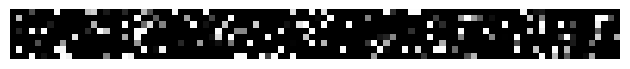

In [13]:
# Example of the data
eg_img, eg_label = ds_train[0]
print("Label:", eg_label)
dispSeq(eg_img)

#### Model

In [14]:
model = Model(INPUT_DIM, NUM_CLASSES, HIDDEN_DIM, ORDER, THETA).to(DEVICE)
optimizer = optim.Adam(params = model.parameters())
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

countParameters(model) # as stated in the paper, the model has ≈102K parameters

NameError: name 'partial' is not defined

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
   
    print(f"Epoch: {epoch+1:02}/{EPOCHS:02}")

    train_loss, train_acc = train(model, dl_train, optimizer, criterion)
    val_loss, val_acc = validate(model, dl_val, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%")
    print()

Epoch: 01/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.690 | Train Acc: 78.18%
Val. Loss: 0.369 |  Val. Acc: 89.31%

Epoch: 02/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.309 | Train Acc: 90.66%
Val. Loss: 0.227 |  Val. Acc: 93.08%

Epoch: 03/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.204 | Train Acc: 93.80%
Val. Loss: 0.163 |  Val. Acc: 95.24%

Epoch: 04/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.146 | Train Acc: 95.55%
Val. Loss: 0.136 |  Val. Acc: 95.72%

Epoch: 05/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.116 | Train Acc: 96.44%
Val. Loss: 0.122 |  Val. Acc: 96.26%

Epoch: 06/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.094 | Train Acc: 97.04%
Val. Loss: 0.112 |  Val. Acc: 96.51%

Epoch: 07/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.076 | Train Acc: 97.56%
Val. Loss: 0.123 |  Val. Acc: 96.10%

Epoch: 08/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.063 | Train Acc: 97.95%
Val. Loss: 0.103 |  Val. Acc: 96.79%

Epoch: 09/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.050 | Train Acc: 98.39%
Val. Loss: 0.097 |  Val. Acc: 97.05%

Epoch: 10/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.045 | Train Acc: 98.52%
Val. Loss: 0.103 |  Val. Acc: 96.94%



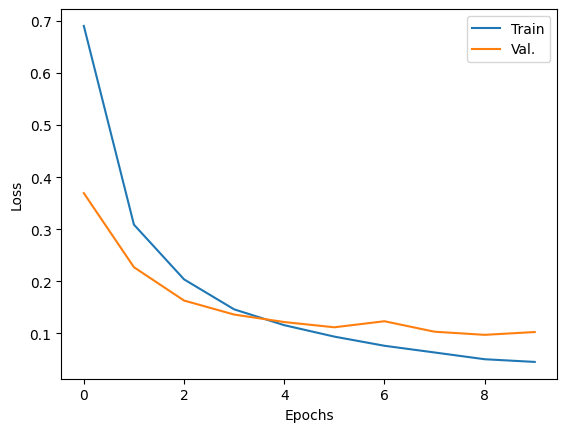

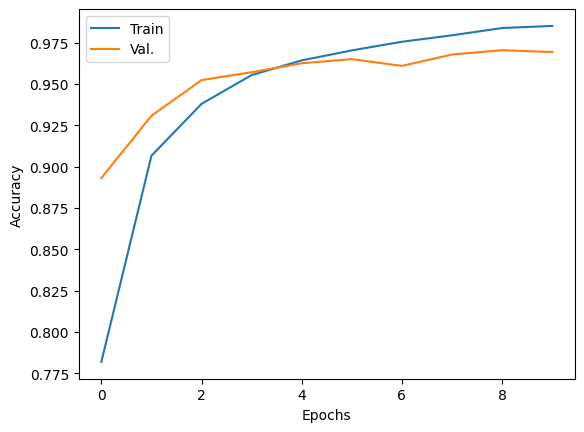

In [ ]:
# Learning curves
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()

plt.plot(range(len(train_accs)), train_accs)
plt.plot(range(len(val_accs)), val_accs)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()